In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import arviz as az
import datetime

In [2]:
import fit_arima

### TO-DOs:

- Ripristinare la posterior_predictive (commentata nel codice STAN e non aggiornata per gestire le varie stazioni)
- Ripristinare la registrazione dei dati mancanti (commentata nel codice fit_arima.py e non aggiornata per gestire le varie stazioni)

## Day Planner
Il modello attualmente considerato è il seguente:

Definita la funzione $\text{sigmoide}$:
$$
\Sigma(z) = \frac{e^z - 1}{e^z + 1}
$$

Sia $s$ l'indice che scorre le stazioni:
$$
s \in \left\{ 1,\dots, S \right\}
$$
allora:
$$
\left. \mathbf{y}_s \right| \gamma_\theta, \underline{\gamma_\phi}, \sigma, \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \text{ARIMA}_{2,1,1}\left( \Sigma(\gamma_{\phi,s}[0]), \Sigma(\gamma_{\phi,s}[1]), \Sigma(\gamma_\theta) , \sigma\right)\\
\left. \gamma_{\phi,s}[j] \right| \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \mathcal{N}\left( \mu_{\phi}[j], \sigma_{\phi}[j] \right), \qquad j \in \left\{ 1,\dots,p \right\} = \left\{ 1,2 \right\}\\
\left. \gamma_\theta \right. \sim \mathcal{N}\left( 0,1 \right)\\
\left. \mu_\phi[j] \right. \sim \mathcal{N}\left( 0,5 \right) \qquad j \in \left\{ 1,\dots,p \right\}\\
\left. \sigma_\phi[j] \right. \sim \mathcal{IG}\left( 2.1,1.1 \right) \qquad j \in \left\{ 1,\dots,p \right\}
$$

L'ARIMA utilizza anche dati precedenti al giorno iniziale trattati come dati mancanti.
I dati mancanti in generale hanno bisogno di prior, che sono state scelte come segue:
$$
y[missing] \sim \mathcal{N}\left( 1,1 \right)
$$
(nel codice STAN sono la variabile 'w')

Tuttavia i dati precedenti i giorni iniziali sono stati trattati diversamente, secondo il modello:
$$
y_{start} | \mu_{start}, \sigma_{start} \sim \mathcal{N}\left( \mu_{start}, \sigma_{start} \right)\\
\mu_{start} \sim \mathcal{N}\left( 1,1 \right)\\
\sigma_{start} \sim \mathcal{IG}\left( 3,2 \right)
$$

Naturalmente se scrivessimo le cose per bene, la likelihood dell'ARIMA dovrebbe essere condizionata anche ai dati mancanti

In [3]:
import open_data
df_temp = open_data.open()
df = df_temp[0]

Nel mio PC (br1) la porzione STAN del codice che segue è stata eseguita in ~ 26 minuti (da notare che prima di inserire le "hyper prior" che rendono il modello gerarchico, si ottenevano tempistiche di ~ 60 minuti)

(Sarebbe bello eseguire tutti il codice correggendo opportunamente in funzione dei core e segnare quanto ci vuole, quindi ad esempio con 4 core inserire catene=4 e samples_per_chain=1000, 6 core catene=6, samples = 750, il tempo da registrare sarebbe quello che appare a destra della barra di caricamento quando STAN termina la computazione)

In [4]:
ritorno = fit_arima.compute(2, 1, catene=4, samples_per_chain=1000, burnin=1000)

18:43:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:01 - cmdstanpy - INFO - CmdStan done processing.
19:00:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: code_model_namespace::log_prob: H is not symmetric. H[1,2] = inf, but H[2,1] = inf (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial_versione_con_condizioni_iniziali_costanti/ARIMA_STAN_matrices/code.stan', line 113, column 2 to column 53)
	Exception: code_model_namespace::log_prob: H is not symmetric. H[1,2] = inf, but H[2,1] = inf (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial_versione_con_condizioni_iniziali_costanti/ARIMA_STAN_matrices/code.stan', line 113, column 2 to column 53)
	Exception: code_model_namespace::log_prob: H is not symmetric. H[1,2] = inf, but H[2,1] = inf (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial_versione_con_condizioni_iniziali_costanti/ARIMA_STAN_matrices/code.stan', line 113, column 2 to column 53)
	Exception: code_model_namespace::log_prob: H is 

pd.set_option('display.max_rows', 500)
az.summary(ritorno['inference_data'], var_names=['phi','theta','betas','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','c','rho','alpha','w_s'])

plt_aux = az.plot_pair(ritorno['inference_data'], var_names=['hyper_gamma_phi_m', 'hyper_gamma_phi_s', 'theta', 'sigma'], divergences=True)

plt_aux = az.plot_trace(ritorno['inference_data'], var_names=['phi','theta','sigma','betas'], divergences=True)

plt_aux = az.plot_posterior(ritorno['inference_data'], var_names=['theta','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','betas','rho','alpha'], hdi_prob=0.95)

plt_aux = az.plot_trace(ritorno['inference_data'], var_names=['rho'], divergences=True)

In [5]:
pd.set_option('display.max_rows', 500)
az.summary(ritorno['inference_data'], var_names=['phi','theta','betas','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','c','alpha','w_s'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"phi[0, 0]",0.685,0.025,0.639,0.732,0.000,0.000,4341.0,2539.0,1.00
"phi[0, 1]",0.662,0.026,0.609,0.708,0.000,0.000,4597.0,3355.0,1.00
"phi[0, 2]",0.671,0.024,0.622,0.715,0.000,0.000,4943.0,3008.0,1.00
"phi[0, 3]",0.653,0.026,0.603,0.702,0.000,0.000,3832.0,2924.0,1.00
"phi[0, 4]",0.672,0.025,0.626,0.720,0.000,0.000,4616.0,2811.0,1.00
"phi[0, 5]",0.678,0.026,0.627,0.723,0.000,0.000,4377.0,2765.0,1.00
"phi[0, 6]",0.691,0.027,0.644,0.742,0.000,0.000,4770.0,2949.0,1.00
"phi[0, 7]",0.704,0.027,0.651,0.752,0.000,0.000,4272.0,3010.0,1.00
"phi[0, 8]",0.706,0.025,0.655,0.753,0.000,0.000,4012.0,2662.0,1.00
"phi[0, 9]",0.700,0.027,0.648,0.748,0.000,0.000,4991.0,2705.0,1.00


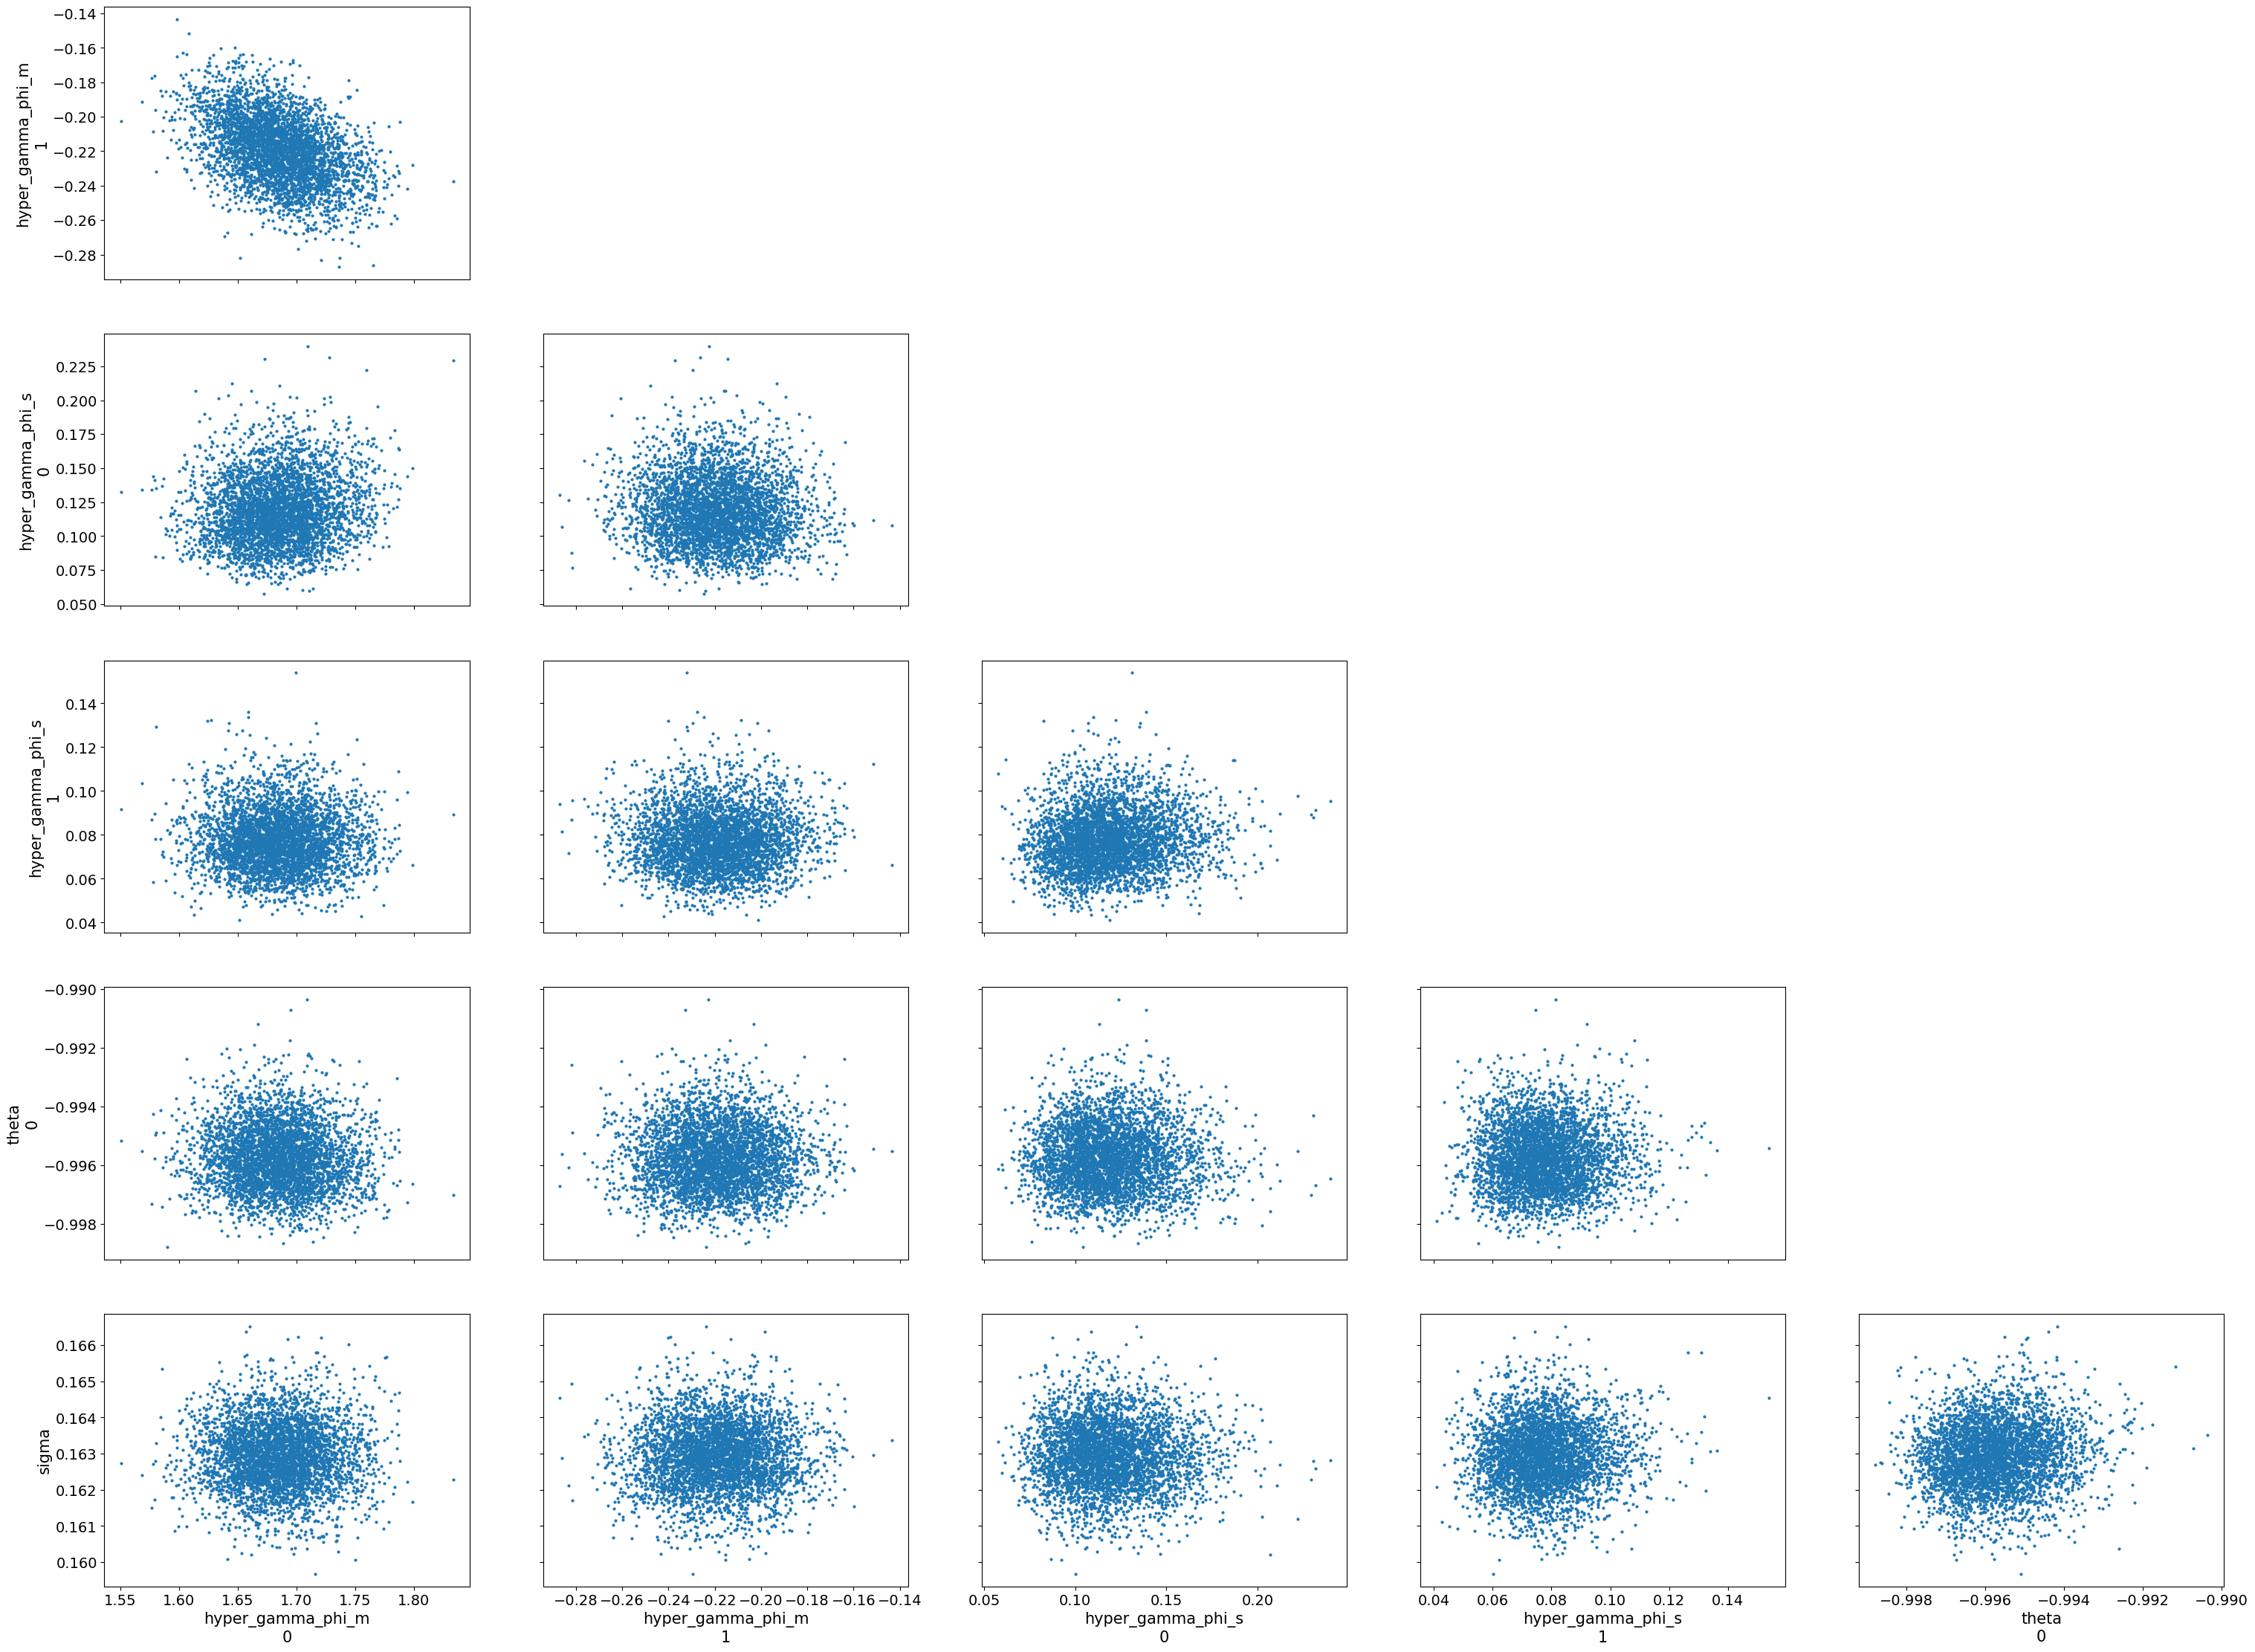

In [6]:
plt_aux = az.plot_pair(ritorno['inference_data'], var_names=['hyper_gamma_phi_m', 'hyper_gamma_phi_s', 'theta', 'sigma'], divergences=True)

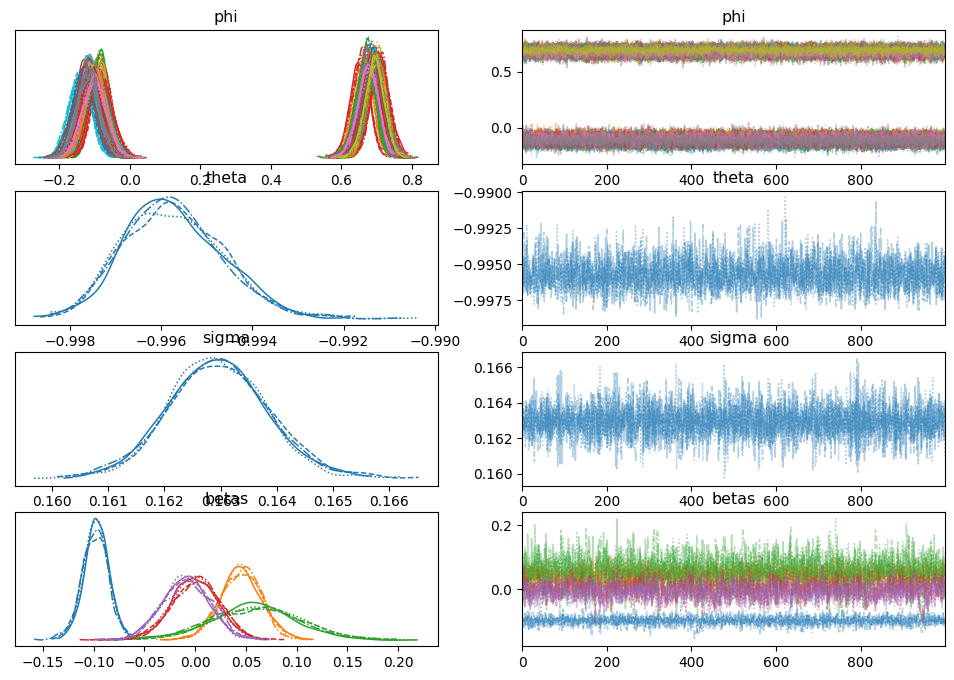

In [7]:
plt_aux = az.plot_trace(ritorno['inference_data'], var_names=['phi','theta','sigma','betas'], divergences=True)

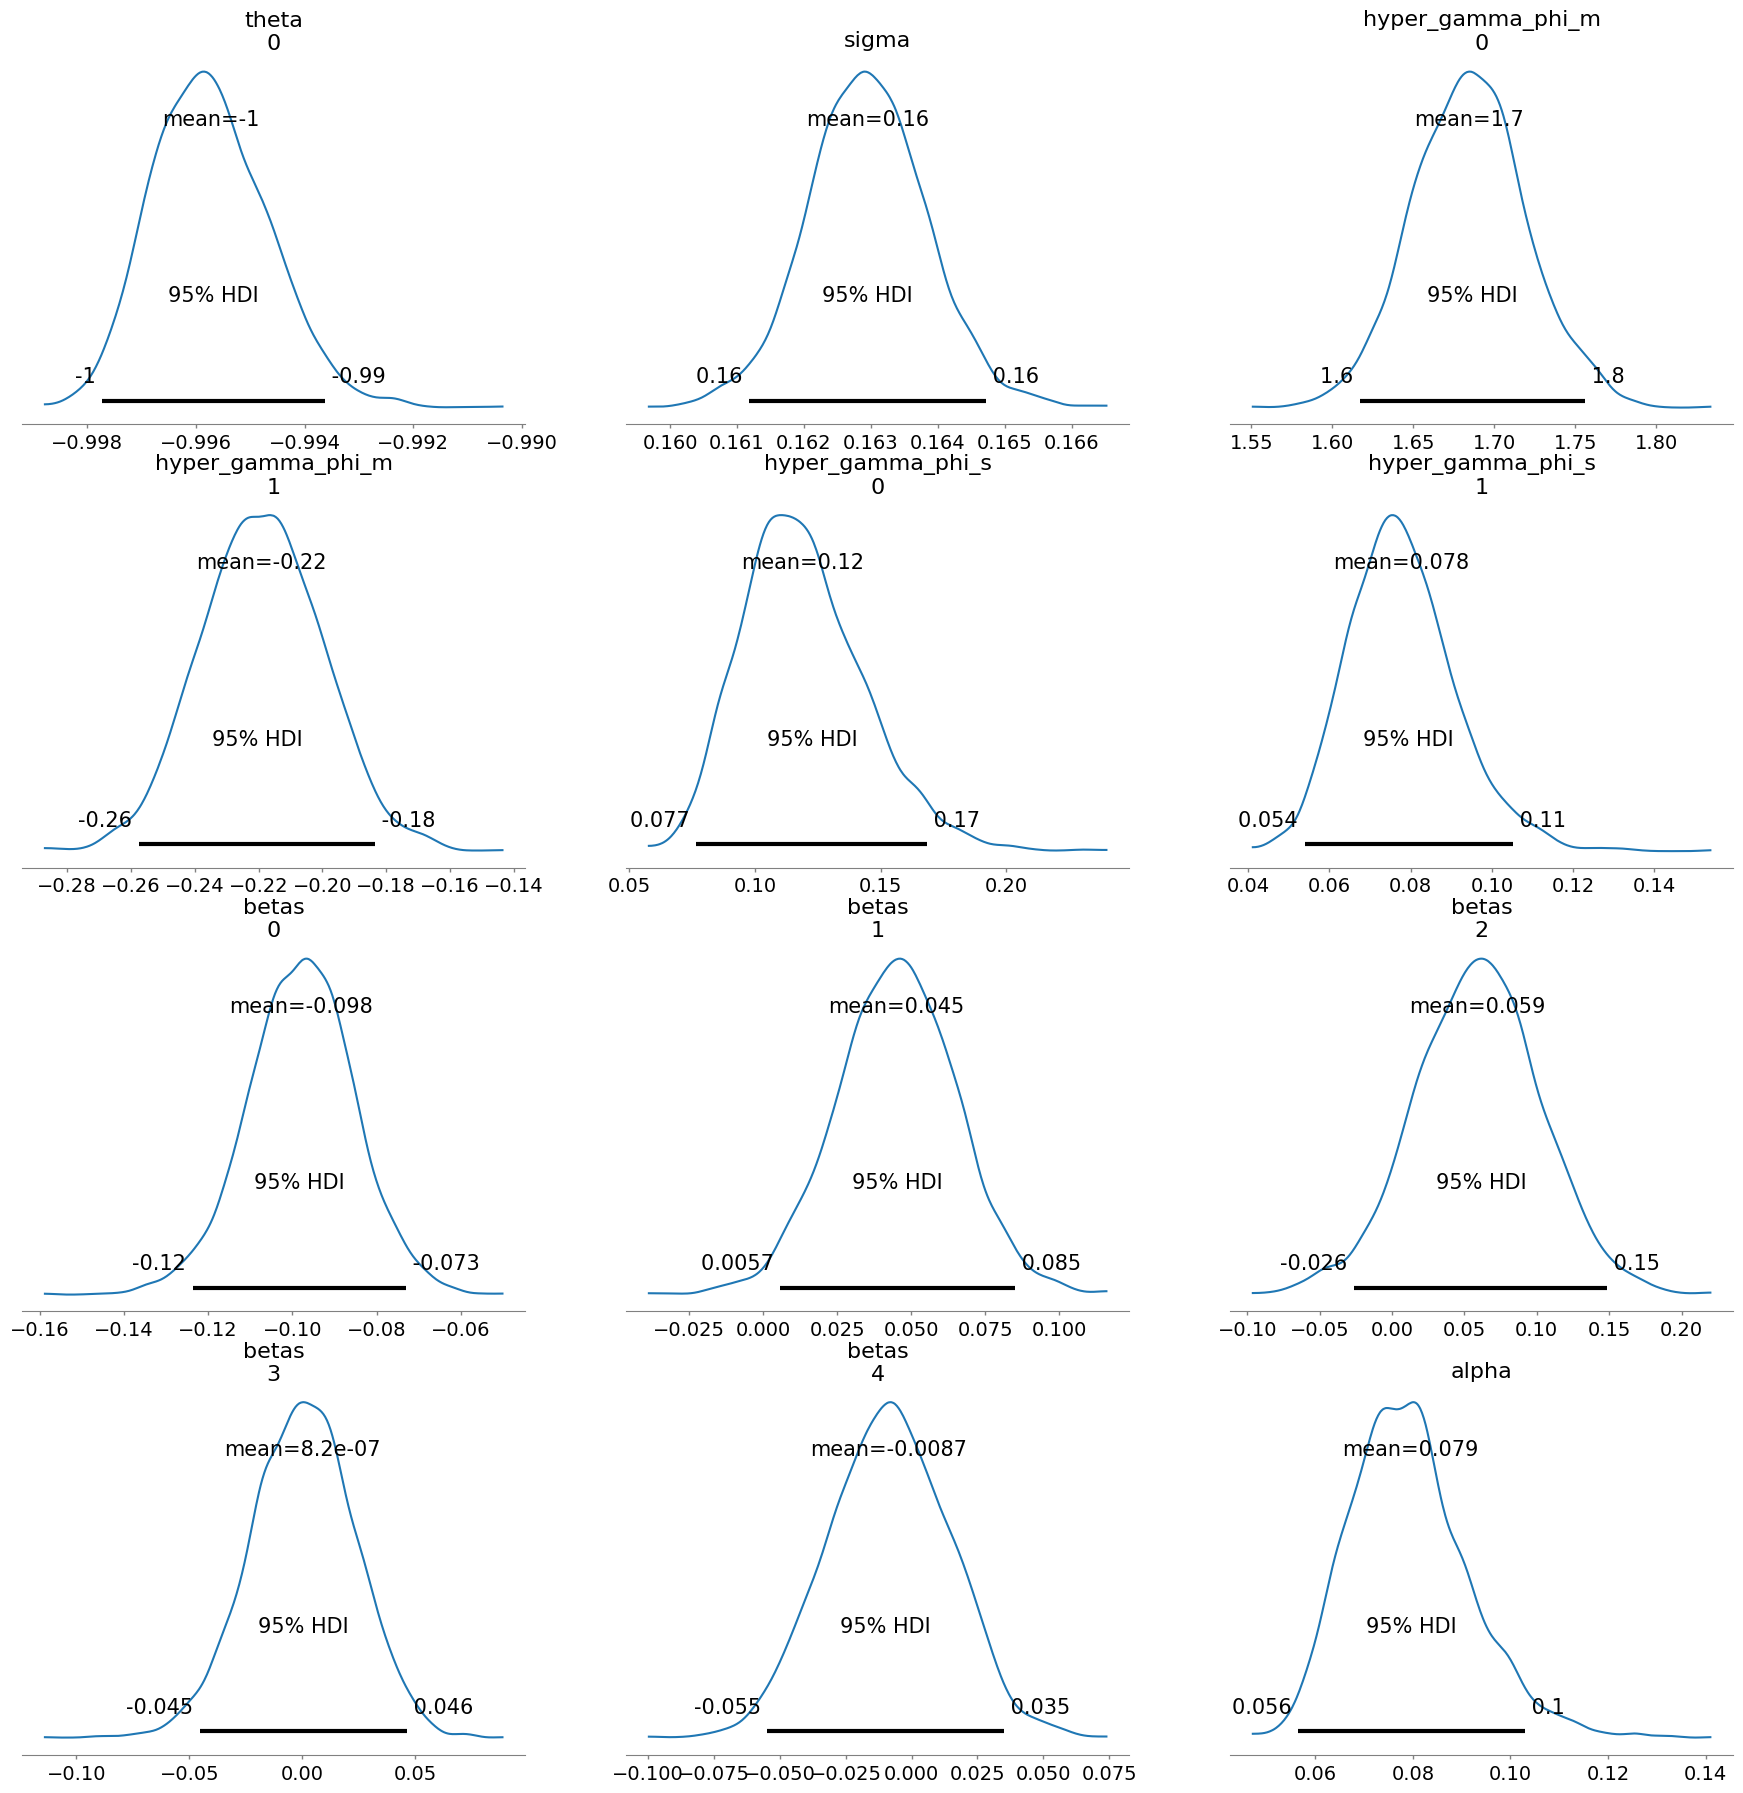

In [8]:
plt_aux = az.plot_posterior(ritorno['inference_data'], var_names=['theta','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','betas','alpha'], hdi_prob=0.95)

<AxesSubplot: ylabel='Density'>

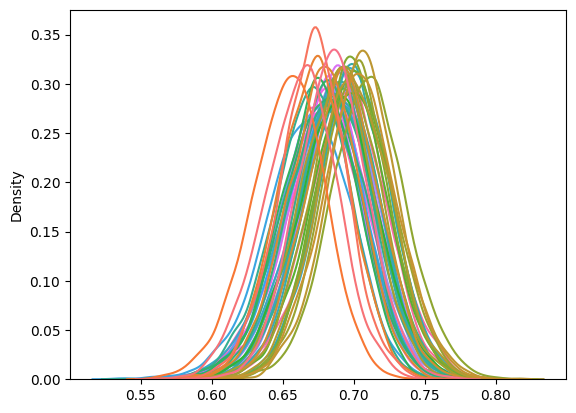

In [9]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,0,:], legend=False)

<AxesSubplot: ylabel='Density'>

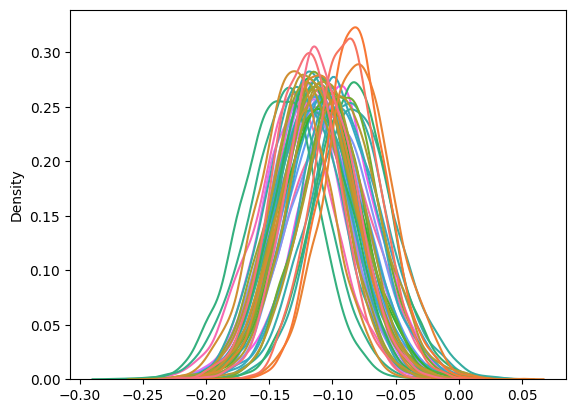

In [10]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,1,:], legend=False)

<AxesSubplot: ylabel='Density'>

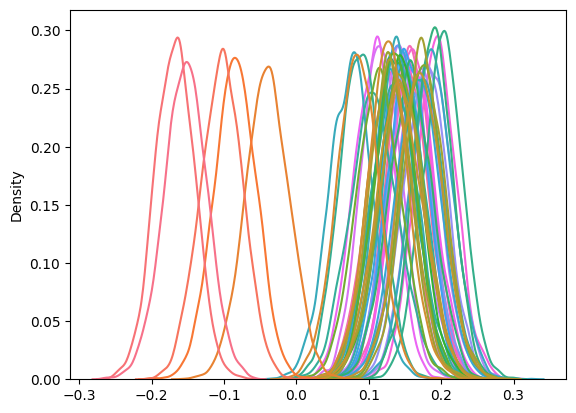

In [11]:
aux_shape = ritorno['inference_data'].posterior.c.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.c.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), legend=False)

<AxesSubplot: ylabel='Density'>

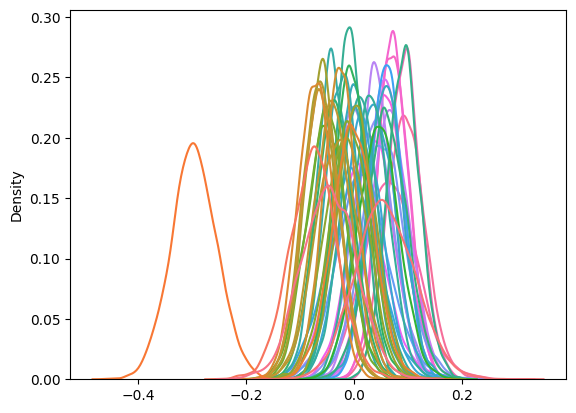

In [12]:
aux_shape = ritorno['inference_data'].posterior.w_s.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.w_s.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), legend=False)

In [13]:
pd.set_option('display.max_columns', 500)
spatial_results = pd.DataFrame(ritorno['inference_data'].posterior.w_s.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), columns=df.columns).describe()
spatial_results.loc['abs_dist_from_mean',:] = (spatial_results.loc['mean',:] - spatial_results.loc['mean',:].mean()).abs()
spatial_results.sort_values('abs_dist_from_mean', axis=1, ascending=False)
#spatial_results.sort_values('mean', axis=1, ascending=True)

,SAVIGNANO DI RIGO,TIMAVO,SAN FRANCESCO,PARCO EDILCARANI,CORTE BRUGNATELLA,VERUCCHIO,CITTADELLA,MONTEBELLO,MARECCHIA,GIARDINI MARGHERITA,DE AMICIS,GERBIDO,S. LAZZARO,CASTELLARANO,SAN LAZZARO,GIARDINI,SARAGAT,SAN PIETRO CAPOFIUME,FEBBIO,PARCO FERRARI,S. ROCCO,CASTELLUCCIO,CENO,PARCO RESISTENZA,PORTA SAN FELICE,ROMA,LUGAGNANO,GIORDANI-FARNESE,PARCO BERTOZZI,PARCO MONTECUCCO,REMESINA,BADIA,ZALAMELLA,FLAMINIA,BESENZONE,FRANCHINI-ANGELONI,DELTA CERVIA,PARADIGNA,SAVIGNANO,GAVELLO,CENTO,SAN LEO,BOGOLESE,GHERARDI,CAORLE,ISONZO,VILLA FULVIA,VIA CHIARINI,MALCANTONE
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.296377,0.094038,0.093222,0.091923,-0.075286,-0.071584,0.073172,0.072741,-0.063063,-0.061284,-0.059688,0.068478,0.066463,0.062187,-0.051408,0.060869,0.060145,-0.050210,0.058202,0.058043,0.057394,-0.046842,0.054536,-0.040557,-0.039039,-0.036301,0.045142,0.041908,-0.030549,0.039594,0.035070,-0.025347,-0.023326,0.032770,0.030256,-0.014746,-0.009466,0.017714,-0.007036,-0.006261,0.013190,-0.002000,-0.001889,-0.000906,0.009430,0.000256,0.001793,0.003536,0.005798
std,0.042080,0.036993,0.030390,0.030207,0.043894,0.031946,0.029281,0.028523,0.032734,0.033768,0.031507,0.049529,0.036620,0.036928,0.038898,0.034157,0.031261,0.035850,0.055412,0.033085,0.032299,0.050317,0.041922,0.036220,0.030564,0.035722,0.038353,0.032338,0.040789,0.035209,0.038143,0.031658,0.032352,0.039267,0.034246,0.039493,0.028355,0.048287,0.038427,0.031104,0.038029,0.038813,0.048249,0.033655,0.034586,0.036286,0.035593,0.035963,0.049066
min,-0.460700,-0.030370,-0.034509,-0.032212,-0.250804,-0.194493,-0.026526,-0.029046,-0.171968,-0.202201,-0.172019,-0.107745,-0.107986,-0.065990,-0.207588,-0.075108,-0.061650,-0.170626,-0.157998,-0.049034,-0.075260,-0.225918,-0.083381,-0.187289,-0.150437,-0.181067,-0.085915,-0.085829,-0.174263,-0.086804,-0.111904,-0.147168,-0.129889,-0.115015,-0.087647,-0.159906,-0.107302,-0.155302,-0.153874,-0.109069,-0.150404,-0.131395,-0.154966,-0.110866,-0.110028,-0.136809,-0.134837,-0.112344,-0.207559
25%,-0.324203,0.068753,0.072985,0.071471,-0.104186,-0.093546,0.053190,0.053610,-0.085239,-0.084046,-0.080885,0.035561,0.041900,0.037303,-0.077262,0.037873,0.039183,-0.074716,0.021256,0.035485,0.036157,-0.081047,0.026994,-0.064093,-0.059603,-0.060005,0.019289,0.020225,-0.058503,0.016320,0.008531,-0.046715,-0.044323,0.006715,0.006795,-0.041522,-0.028537,-0.014718,-0.032560,-0.027102,-0.012475,-0.027360,-0.034043,-0.023544,-0.013599,-0.023453,-0.022525,-0.020528,-0.025971
50%,-0.297021,0.093676,0.093514,0.092217,-0.074922,-0.071620,0.072679,0.072049,-0.063435,-0.061944,-0.059914,0.066759,0.065925,0.061069,-0.051959,0.059920,0.059860,-0.050464,0.056095,0.057957,0.057753,-0.046955,0.053219,-0.040507,-0.039679,-0.036459,0.045149,0.040990,-0.030767,0.038914,0.035599,-0.025998,-0.022706,0.032740,0.030011,-0.014804,-0.009437,0.016466,-0.007660,-0.006830,0.013439,-0.002481,-0.003461,-0.001038,0.009199,0.000214,0.001365,0.003256,0.005751
75%,-0.268300,0.117901,0.113090,0.111477,-0.046882,-0.049858,0.092843,0.091535,-0.040735,-0.038987,-0.038748,0.100667,0.090666,0.087162,-0.026131,0.083346,0.080603,-0.026344,0.095292,0.079624,0.079360,-0.011993,0.080379,-0.016521,-0.018467,-0.012806,0.070433,0.063413,-0.004111,0.063977,0.060573,-0.005167,-0.002396,0.058870,0.053117,0.012101,0.009565,0.047960,0.018884,0.014720,0.039581,0.023548,0.029659,0.021388,0.032214,0.024356,0.025753,0.027628,0.037953
max,-0.150067,0.252672,0.206632,0.19

In [14]:
y_post_pred = ritorno['inference_data'].posterior.y_post_pred.to_numpy()
y_post_pred = y_post_pred.reshape(y_post_pred.shape[0]*y_post_pred.shape[1], y_post_pred.shape[2], y_post_pred.shape[3])
y_post_pred.shape

(4000, 365, 49)

In [15]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [16]:
@widgets.interact(stazione = df.columns)
def f(stazione):
    col_map = sns.light_palette((20, 75, 70), input='husl', as_cmap=True)

    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,1,1)

    idx_stazione = df.columns.to_list().index(stazione)
    
    """
    sns.lineplot(np.transpose(y_post_pred[0:50,:,idx_stazione]))
    """

    lower_lim = np.zeros(len(df.index))
    upper_lim = np.zeros(len(df.index))    
    for i in range(len(df.index)):
        lower_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],2.5)
        upper_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],97.5)
    
    
#    sns.lineplot(lower_lim)
#    sns.lineplot(upper_lim)
    
    for i in range(len(df.index)):
        ax.add_patch(mplt.patches.Rectangle((i,lower_lim[i]),1,upper_lim[i]-lower_lim[i], fill=True, color=col_map(180)))

    sns.lineplot(df[stazione])    
    sns.lineplot(np.mean(y_post_pred[:,:,idx_stazione], axis=0))


    index = 0
    for line in ax.get_lines():
        if index == 0:
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(155))
        else:
            col_map = sns.dark_palette((10,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
        index += 1
        
    plt.ylim(bottom=0,top=2.5)

    primo_giorno = datetime.date(2018,1,1)
    date_da_segnare = []
    date_da_segnare_posizioni = []

    for i in range(12):
        date_da_segnare.append(datetime.date(2018,i+1,1))
        date_da_segnare_posizioni.append((date_da_segnare[2*i] - primo_giorno).days)
        date_da_segnare.append(datetime.date(2018,i+1,15))
        date_da_segnare_posizioni.append((date_da_segnare[2*i+1] - primo_giorno).days)
        date_da_segnare[2*i] = date_da_segnare[2*i].isoformat()
        date_da_segnare[2*i+1] = date_da_segnare[2*i+1].isoformat()

    plt.xticks(date_da_segnare_posizioni,date_da_segnare,rotation=65)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.grid()
    
    """
    ax.get_legend().remove()
    col_vals = np.linspace(1,255,num=len(df.columns))
    index = 0
    for line in ax.get_lines():
        if(index == len(ax.get_lines()) - 1):
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            continue
        if(index == len(ax.get_lines()) - 2):
            col_map = sns.dark_palette((120,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            index += 1
            continue

        #line.set_c(col_map(int(np.round(col_vals[index]))))
        line.set_c(col_map(220))
        line.set_alpha(0.3)
        index += 1
    """
    
    

    plt.show()

interactive(children=(Dropdown(description='stazione', options=('CASTELLUCCIO', 'FEBBIO', 'CORTE BRUGNATELLA',…

In [17]:
def f(stazione):
    col_map = sns.light_palette((20, 75, 70), input='husl', as_cmap=True)

    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,1,1)

    idx_stazione = df.columns.to_list().index(stazione)
    
    """
    sns.lineplot(np.transpose(y_post_pred[0:50,:,idx_stazione]))
    """

    lower_lim = np.zeros(len(df.index))
    upper_lim = np.zeros(len(df.index))    
    for i in range(len(df.index)):
        lower_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],2.5)
        upper_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],97.5)
    
    
#    sns.lineplot(lower_lim)
#    sns.lineplot(upper_lim)
    
    for i in range(len(df.index)):
        ax.add_patch(mplt.patches.Rectangle((i,lower_lim[i]),1,upper_lim[i]-lower_lim[i], fill=True, color=col_map(180)))

    sns.lineplot(df[stazione])    
    sns.lineplot(np.mean(y_post_pred[:,:,idx_stazione], axis=0))


    index = 0
    for line in ax.get_lines():
        if index == 0:
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(155))
        else:
            col_map = sns.dark_palette((10,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
        index += 1
        
    plt.ylim(bottom=0,top=2.5)

    primo_giorno = datetime.date(2018,1,1)
    date_da_segnare = []
    date_da_segnare_posizioni = []

    for i in range(12):
        date_da_segnare.append(datetime.date(2018,i+1,1))
        date_da_segnare_posizioni.append((date_da_segnare[2*i] - primo_giorno).days)
        date_da_segnare.append(datetime.date(2018,i+1,15))
        date_da_segnare_posizioni.append((date_da_segnare[2*i+1] - primo_giorno).days)
        date_da_segnare[2*i] = date_da_segnare[2*i].isoformat()
        date_da_segnare[2*i+1] = date_da_segnare[2*i+1].isoformat()

    plt.xticks(date_da_segnare_posizioni,date_da_segnare,rotation=65)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.grid()
    
    """
    ax.get_legend().remove()
    col_vals = np.linspace(1,255,num=len(df.columns))
    index = 0
    for line in ax.get_lines():
        if(index == len(ax.get_lines()) - 1):
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            continue
        if(index == len(ax.get_lines()) - 2):
            col_map = sns.dark_palette((120,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            index += 1
            continue

        #line.set_c(col_map(int(np.round(col_vals[index]))))
        line.set_c(col_map(220))
        line.set_alpha(0.3)
        index += 1
    """
    
    

    plt.show()

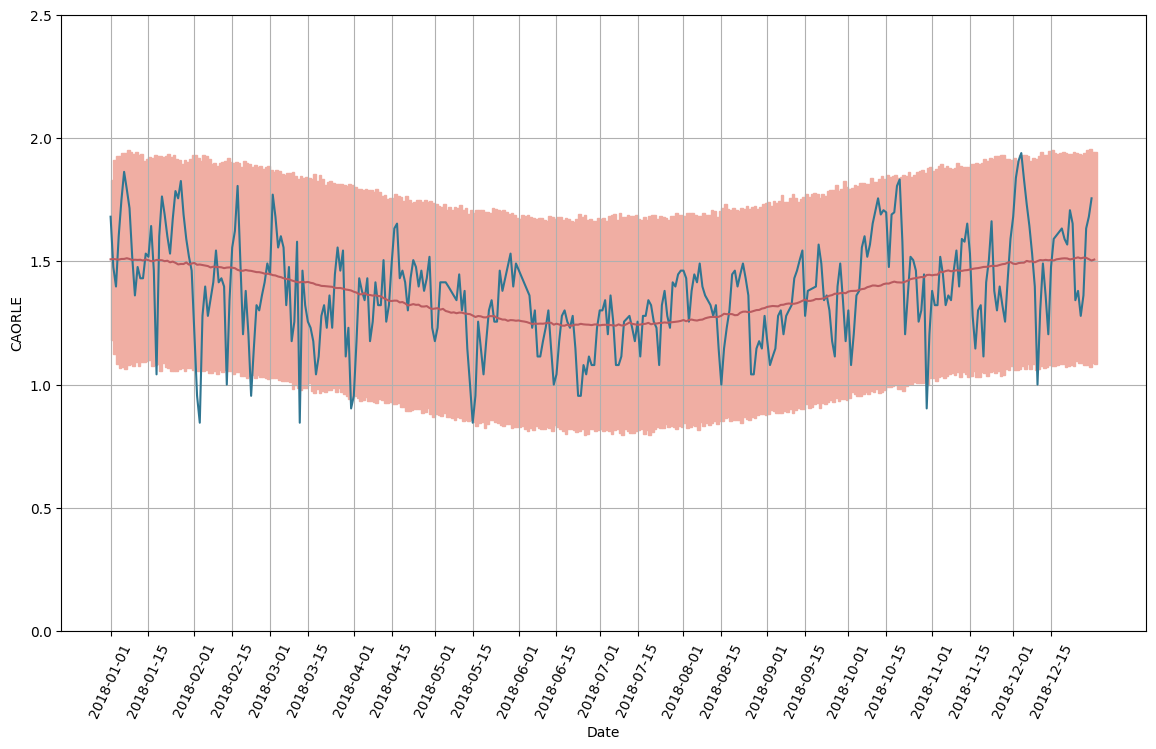

In [18]:
f('CAORLE')

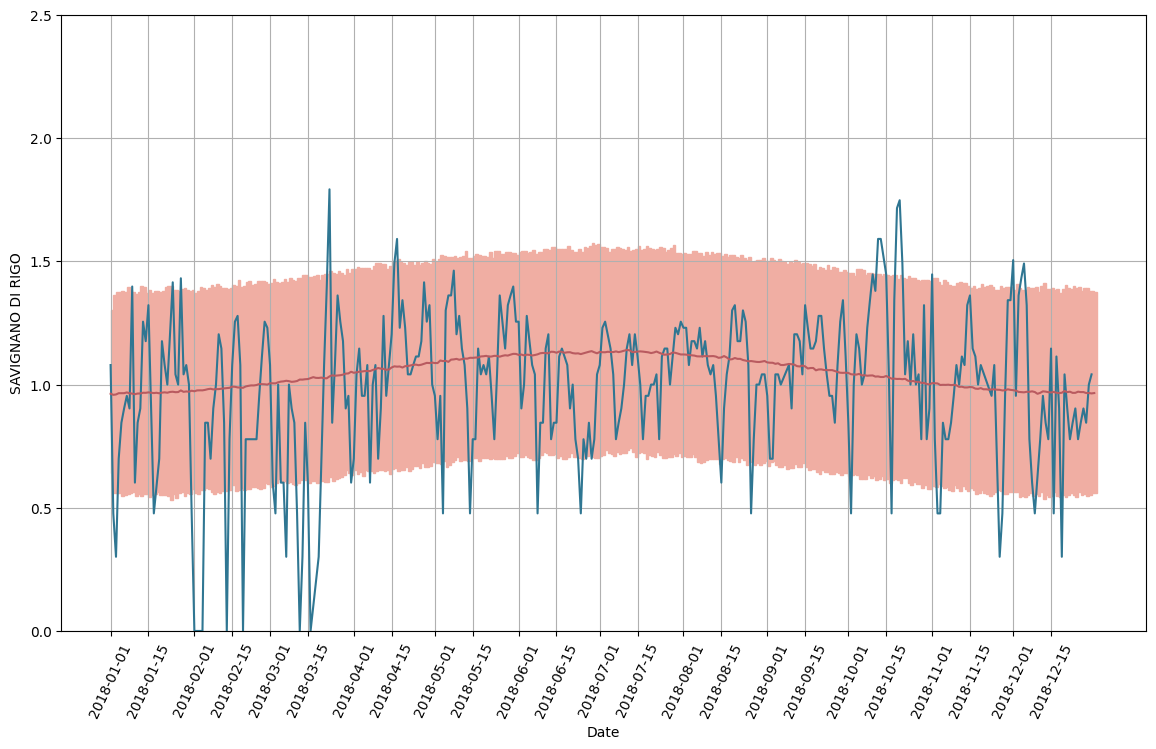

In [19]:
f('SAVIGNANO DI RIGO')